In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

In [2]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

## Optimization formula:
## $\underset{\theta}{\max} \frac{1}{T} \sum^{T-1}_{t=0} u\left( \sum_{i=1}^{N_{t}}( \bar{w}_{i,t} + \frac{1}{N_{t}}\theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} \right) $

## Critical point of formula:

## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $


## Utility function

## $u(r_{p,t+1}) = \frac{(1+r_{p,t+1})^{1-\gamma}}{1-\gamma} $

## Portfolio return
## $ r_{p,t+1} = \sum^{N_{t}}_{i=1} \bar{w}_{i,t} r_{i,t+1} + \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} $


## Utility function derivate

## $u'(r_{p,t+1}) = (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} $

## Portfolio return derivate
## $ r'_{p,t+1} = \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \hat{x}_{i,t} ) r_{i,t+1} = \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} $

## Critical point expanded:
## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} (r'_{p, t+1})^2 $

In [364]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

time = 90 # 90 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# random initialization of theta for 3 firm characteristics
theta = np.random.rand(1, 3)
w = np.empty(shape=(number_of_stocks, time))
# Learning rate
lr = 1e-10
epochs = 100
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics
#         if i>=5:
#             # Negative return firms
#             me = np.random.uniform(0,1)
#             btm = np.random.uniform(-1,0)
#             mom = np.random.uniform(-1,0)
#         else:
#             # Positive return firms
#             me = np.random.uniform(-1,0)
#             btm = np.random.uniform(0,1)
#             mom = np.random.uniform(0,1)
        me = np.random.uniform(-1,1)
        btm = np.random.uniform(-1,1)
        mom = np.random.uniform(-1,1)
            
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)
# Normalize firm characteristics for each stock
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()

Created all artificial stocks


In [365]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [366]:
for k in tqdm(range(epochs)):
    r_p_grad=0
    r_p = 0
    # Optmize Theta over all stocks and times
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        # Multiply only t-1 firm characteristics
        # Starting return r at t+1
        r_p_grad += firm_df[:-1].T * r[i, 1:]
        r_p +=  w_benchmark[i,:-1]*r[i, 1:] + (1/number_of_stocks)*firms_coeff[:,:-1]*r[i, 1:]
    r_p_grad *= (1/number_of_stocks)
    u_grad = np.power((1+r_p),-gamma)
    gradient = (np.power(r_p_grad,2) * u_grad).T.sum()/time
    
    theta += lr * gradient

#     print(f" Theta :{theta}, k:{k}")
    # Avaliate function
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        w[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    
    # Using t-1 weights and r from 1 to t
    r_p = sum(w[:,:-1]*r[:,1:])
    utility_values = utility_function(5, r_p)
    # Average over T 
    average_return_portifolio = sum(utility_values)/len(utility_values)
    return_all.append(average_return_portifolio)
#     print(f"Return {average_return_portifolio}")
print(f"Finished running {epochs} epochs")


Finished running 100 epochs


In [356]:
w_benchmark[:,0].sum()

1.0

In [357]:
theta

array([[0.65412, -2.26679, -2.16334]])

In [358]:
w[:,0].sum()

0.9999999999999998

In [359]:
w[:,0]

array([0.04464, 0.15779, 0.02482, 0.23090, 0.14564, -0.12232, 0.05831,
       0.15941, 0.22153, 0.07928])

In [360]:
pd.DataFrame(return_all).describe()

,0
count,1.000000e+01
mean,-8.947542e+06
std,2.796768e+07
min,-8.854059e+07
25%,-3.603598e+02
50%,-3.603576e+02
75%,-3.603553e+02
max,-3.603530e+02


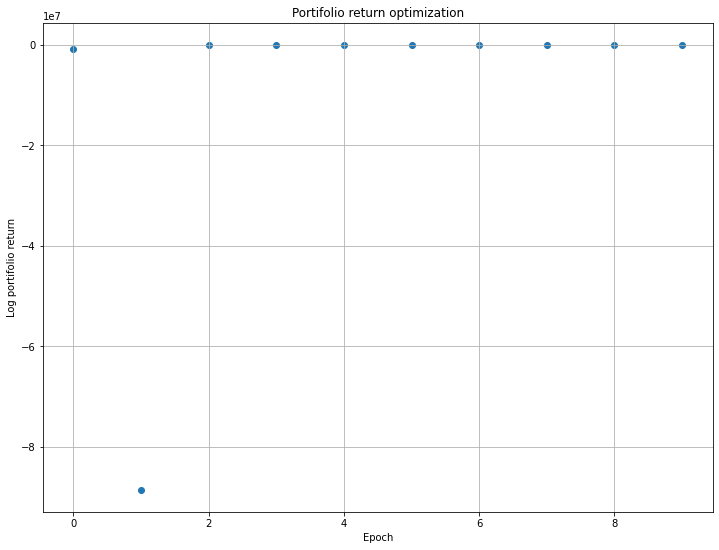

In [363]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.scatter(x=range(len(return_all)), y=return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.xlabel('Epoch')
plt.grid()
plt.show()

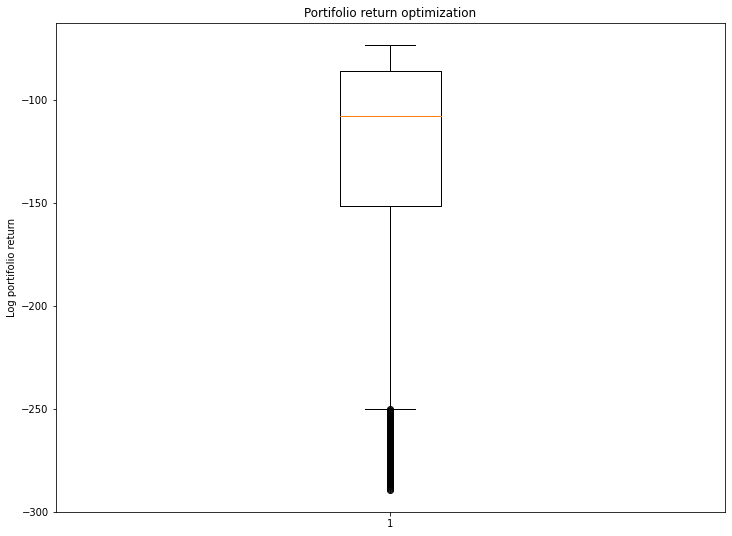

In [46]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.boxplot(return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.show()

In [5]:
last_return = average_return_portifolio

In [6]:
former_w = w.copy()

In [7]:
r_p = np.array([sum(w[:,t]*r[:,t+1]) for t in range(time-1)])
utility_values = utility_function(5, r_p)
# Average over T 
average_return_portifolio = sum(utility_values)/len(utility_values)

In [8]:
normalization_term = []
for i in range(time):
    normalization_term.append(w[:,i].sum().copy())
    w[:,i] = w[:,i]/w[:,i].sum()

In [41]:
w[:,0]

array([ 0.11879961, -0.18056471,  0.15255279,  0.26060101, -0.40742294,
        0.46645446,  0.33931976,  0.37553854,  0.08007123, -0.20534976])

In [42]:
former_utility_values = utility_values

In [60]:
r_p = np.array([sum(w[:,t]*r[:,t+1]) for t in range(time-1)])
utility_values = utility_function(5, r_p *normalization_term[:-1])

In [61]:
utility_values

array([-1.15351788e+04, -8.10674387e-02, -1.72490501e-01, -1.02453398e+01,
       -3.78284448e-02, -2.63886606e-01, -2.27946326e-01, -3.43868119e-01,
       -2.68805161e-01, -1.51363269e-01, -1.34668786e+00, -1.46147342e-01,
       -2.05180290e-01, -1.88575766e-01, -2.81592141e-01, -1.52562188e-01,
       -1.10558611e-01, -4.67478053e-02, -1.10902996e-01, -8.39010626e-02,
       -4.14853582e-01, -2.69712807e+00, -7.08100762e-02, -1.78063080e-01,
       -9.40411297e-02, -1.99932443e-01, -1.12639431e+01, -1.20877191e+01,
       -7.90692702e+00, -7.99481516e-02, -5.33425098e-01, -1.71292318e+01,
       -5.23172888e-02, -5.13787932e-02, -1.40865346e-01, -3.43699514e-01,
       -3.85592011e-01, -1.52777783e+00, -1.87004007e-01, -4.81272189e-01,
       -1.54164130e-01, -2.86998635e-01, -2.13826603e-01, -1.60518781e-01,
       -2.95134775e-01, -5.44184836e+00, -3.86855917e-01, -9.59112636e-01,
       -1.60146840e-01, -1.35331042e-01, -4.53033734e-01, -1.99931110e+00,
       -1.46013393e-01, -

In [ ]:


# benchmark portifolio weight of stock i on time t
w_i_t_bench = 1.0

# weight of stock i on time t
w_i_t = w_i_t_bench + (1/number_of_stocks)*X.dot(firm_characteristics)

# Where X is a vector of coefficients that we want to find and firm_characteristics are a vector of firm characteristics.


In [64]:
(sum(utility_values)/len(utility_values))

-132.85954077998355

In [33]:
sum(former_utility_values)/len(former_utility_values)

-132.85954077998355

In [68]:
r_p *normalization_term[:-1]

array([-0.93176944,  0.32517547,  0.09721998, -0.60476681,  0.60335755,
       -0.01342373,  0.02335627, -0.07660605, -0.01796809,  0.13365231,
       -0.34360046,  0.14363456,  0.05063313,  0.07303412, -0.02931153,
        0.1314185 ,  0.22627213,  0.52070403,  0.22531904,  0.31384199,
       -0.11892822, -0.44822806,  0.37075941,  0.08853283,  0.27689605,
        0.05746057, -0.61402214, -0.62077329, -0.57831994,  0.32978949,
       -0.17259786, -0.6524234 ,  0.47850805,  0.48521398,  0.15420768,
       -0.07649283, -0.10266833, -0.3639812 ,  0.07528175, -0.15103984,
        0.12846779, -0.03391566,  0.0398473 ,  0.11712955, -0.04064376,
       -0.53703475, -0.10340215, -0.28547472,  0.11777762,  0.16583113,
       -0.13810896, -0.40534523,  0.14389676,  0.06144632,  0.43896461,
        0.16776597,  0.1668767 , -0.04643061,  0.22806073, -0.13991716,
       -0.05604722, -0.36530144, -0.4809497 ,  0.37016617,  0.35121843,
       -0.05315096, -0.14262215,  0.03872905, -0.80631705, -0.03

In [71]:
r_p_old = np.array([sum(former_w[:,t]*r[:,t+1]) for t in range(time-1)])
r_p_old

array([-0.93176944,  0.32517547,  0.09721998, -0.60476681,  0.60335755,
       -0.01342373,  0.02335627, -0.07660605, -0.01796809,  0.13365231,
       -0.34360046,  0.14363456,  0.05063313,  0.07303412, -0.02931153,
        0.1314185 ,  0.22627213,  0.52070403,  0.22531904,  0.31384199,
       -0.11892822, -0.44822806,  0.37075941,  0.08853283,  0.27689605,
        0.05746057, -0.61402214, -0.62077329, -0.57831994,  0.32978949,
       -0.17259786, -0.6524234 ,  0.47850805,  0.48521398,  0.15420768,
       -0.07649283, -0.10266833, -0.3639812 ,  0.07528175, -0.15103984,
        0.12846779, -0.03391566,  0.0398473 ,  0.11712955, -0.04064376,
       -0.53703475, -0.10340215, -0.28547472,  0.11777762,  0.16583113,
       -0.13810896, -0.40534523,  0.14389676,  0.06144632,  0.43896461,
        0.16776597,  0.1668767 , -0.04643061,  0.22806073, -0.13991716,
       -0.05604722, -0.36530144, -0.4809497 ,  0.37016617,  0.35121843,
       -0.05315096, -0.14262215,  0.03872905, -0.80631705, -0.03

In [17]:
w[:,0]

array([ 0.02213505, -0.03740161,  0.02678427,  0.02385859, -0.07132726,
        0.09471435,  0.05150448,  0.0536741 , -0.00410835, -0.0306466 ])

In [20]:
r_p

array([-0.97617954,  0.58264825, -0.4093089 , -0.32979177,  0.14115482,
       -0.14291239,  0.34416877, -0.63604453, -0.17889924, -0.29261797,
       -0.22095745,  0.08506735, -0.27314058,  0.02462011, -0.00324144,
       -0.30633321, -0.11025638,  0.14083416,  0.40528208,  0.77801396,
        0.0906956 , -0.14443267,  0.17882346,  0.3486114 , -0.05271025,
        0.55152616,  0.14368529, -0.47158275, -0.79818353, -0.30535779,
        0.08490633,  0.04179894,  0.05239237, -0.361158  ,  0.19962287,
       -0.09167087,  0.25853597, -0.3048806 ,  0.46738311,  0.21256192,
       -0.37040469, -0.44589849, -0.19808088,  0.76698131, -0.73746695,
       -0.31867781,  0.45356017,  0.48753229,  0.19887639, -0.03549526,
        0.75158927,  0.02059273,  0.50198445, -0.27560341,  0.11070061,
        0.09902476,  0.03874077, -0.29588656, -0.67387402, -0.21144996,
        0.14627551, -0.84799171,  0.13966724,  0.21112944,  0.0266372 ,
        0.2441221 ,  0.41181768,  0.44752614, -1.13425962,  0.57